In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset/yield_df.csv
dataset/yield.csv
dataset/pesticides.csv
dataset/rainfall.csv
dataset/temp.csv


While this notebook has the intention of been and excercise / review / first steps for our final ML project. I use the 4 original files to do my own Data-frame.

Taking acount that the files containing the information about pesticides, rainfall and temperatures are linked to a geographic zone (always country?), we're going to try to create a unique DF containing all the data attached to a geographic zone and a year.

### Working in yield

In [2]:
df_yield = pd.read_csv(dirname + "/" + filenames[1])
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


We analyse the information inside the 'yield' dataframe, and than select those attributs of interest

In [3]:
df_yield.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Domain Code'].describe()# unique = 1 this coloumn isn't giving us new information, we can eliminate it.
tmp = np.where(df_yield['Year Code'] != df_yield['Year']) # This 2 columns have exactly the same info.
df_yield['Unit'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Element'].describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_yield['Area'].describe() #212 countries

# So, we create the new dataset putting only the meaningful data we found.
df = df_yield.loc[:,['Area','Item','Year','Value']]
df.shape

(56717, 4)

### Working in temp

In [4]:
df_temp = pd.read_csv(dirname + "/" + filenames[4])
df_temp.columns = df_temp.columns.str.replace('year', 'Year') # I changed the
df_temp.columns = df_temp.columns.str.replace('country', 'Area')
df_temp.head()
# print(df_temp.shape[0]+df_yield.shape[0])

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


Here we merge 'yield' and 'temp' datasets. The primary key used to do so is an ensemble 'Year' and 'Area'

In [5]:
df.Year.describe()
df = pd.merge(df, df_temp, how='inner', on = ['Year', 'Area'])
df.columns = df.columns.str.replace('Value', "yield_hg/ha")
df

,Area,Item,Year,yield_hg/ha,avg_temp
0,Afghanistan,Maize,1961,14000,14.23
1,Afghanistan,Potatoes,1961,86667,14.23
2,Afghanistan,"Rice, paddy",1961,15190,14.23
3,Afghanistan,Wheat,1961,10220,14.23
4,Afghanistan,Maize,1962,14000,14.10
...,...,...,...,...,...
84854,Zimbabwe,"Rice, paddy",2013,22581,19.76
84855,Zimbabwe,Sorghum,2013,3066,19.76
84856,Zimbabwe,Soybeans,2013,13142,19.76
84857,Zimbabwe,Sweet potatoes,2013,22222,19.76


In [6]:
print(df.isna().sum())
# I confirmed there's not NaNs ! In this case we apparently have a super good quality dataset.

Area           0
Item           0
Year           0
yield_hg/ha    0
avg_temp       0
dtype: int64


### Working in rainfall

In [7]:
df_rainfall = pd.read_csv(dirname + "/" + filenames[3])
df_rainfall.columns = df_rainfall.columns.str.replace('average_rain_fall_mm_per_year', 'rain_mm_year')
df_rainfall.columns = df_rainfall.columns.str.replace(' Area', 'Area')
df_rainfall

,Area,Year,rain_mm_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327
...,...,...,...
6722,Zimbabwe,2013,657
6723,Zimbabwe,2014,657
6724,Zimbabwe,2015,657
6725,Zimbabwe,2016,657


Merging the 'rainfall' information into the dataframe we had so far

In [8]:
df = pd.merge(df, df_rainfall, how='inner', on = ['Year', 'Area'])
df

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year
0,Afghanistan,Maize,1985,16652,15.52,327
1,Afghanistan,Potatoes,1985,140909,15.52,327
2,Afghanistan,"Rice, paddy",1985,22482,15.52,327
3,Afghanistan,Wheat,1985,12277,15.52,327
4,Afghanistan,Maize,1986,16875,14.71,327
...,...,...,...,...,...,...
44130,Zimbabwe,"Rice, paddy",2013,22581,19.76,657
44131,Zimbabwe,Sorghum,2013,3066,19.76,657
44132,Zimbabwe,Soybeans,2013,13142,19.76,657
44133,Zimbabwe,Sweet potatoes,2013,22222,19.76,657


In [9]:
print(df.isna().sum())

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
dtype: int64


### Working in pesticides

In [10]:
df_pesticides = pd.read_csv(dirname + "/" + filenames[2])
df_pesticides.head()


,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [11]:
df_pesticides.Item.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Element.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Domain.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.Unit.describe() # unique = 1 this coloumn isn't giving us new information, we can eliminate it.
df_pesticides.columns = df_pesticides.columns.str.replace('Value', 'ton_pest')


In [12]:
df = pd.merge(df, df_pesticides.loc[:,['Area', 'Year', 'ton_pest']], how='inner', on = ['Year', 'Area'])
print(df.isna().sum())
df

Area            0
Item            0
Year            0
yield_hg/ha     0
avg_temp        0
rain_mm_year    0
ton_pest        0
dtype: int64


,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest
0,Albania,Maize,1990,36613,16.37,1485,121.00
1,Albania,Potatoes,1990,66667,16.37,1485,121.00
2,Albania,"Rice, paddy",1990,23333,16.37,1485,121.00
3,Albania,Sorghum,1990,12500,16.37,1485,121.00
4,Albania,Soybeans,1990,7000,16.37,1485,121.00
...,...,...,...,...,...,...,...
28243,Zimbabwe,"Rice, paddy",2013,22581,19.76,657,2550.07
28244,Zimbabwe,Sorghum,2013,3066,19.76,657,2550.07
28245,Zimbabwe,Soybeans,2013,13142,19.76,657,2550.07
28246,Zimbabwe,Sweet potatoes,2013,22222,19.76,657,2550.07


At this point we have a complete dataset, the ideal now is to explore this dataset using some exploratory statistics techniques to understand the dependences, correlations and patterns between attributs.

## cleaning dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28248 non-null  object 
 1   Item          28248 non-null  object 
 2   Year          28248 non-null  int64  
 3   yield_hg/ha   28248 non-null  int64  
 4   avg_temp      28248 non-null  float64
 5   rain_mm_year  28248 non-null  object 
 6   ton_pest      28248 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


We notice that 'rain_mm_year' is a data of type 'object' when it should be of a numeric type. After some investigation, it's possible to see that there were some values in this column that were no valid information, represented by two dots. We drop these values out and keep the new DF with 'rain_mm_year' as a float data

In [14]:
# We have just to correct the dataType of rain_mm_year

# There is something that we can't not convert in float, to find it i used an easy approach with a for cycle and a try-except control structure.
for raindata in df.rain_mm_year:
    try:
        raindata = float(raindata)
    except:
        print(raindata)
        
tmp = np.where(df.rain_mm_year == '..')
df = df.drop(list(tmp[0]))
# Now we can done the correct dataType to the attribute

df.rain_mm_year = df.rain_mm_year.astype('float')
df.info()

..
..
..
..
..
..
<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28242 non-null  object 
 1   Item          28242 non-null  object 
 2   Year          28242 non-null  int64  
 3   yield_hg/ha   28242 non-null  int64  
 4   avg_temp      28242 non-null  float64
 5   rain_mm_year  28242 non-null  float64
 6   ton_pest      28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


# Exploratory analyses

In [15]:
df.Year = df.Year.astype('object')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yield_hg/ha,28242.0,77053.332094,84956.612897,50.00,19919.2500,38295.00,104676.75,501412.00
avg_temp,28242.0,20.542627,6.312051,1.30,16.7025,21.51,26.00,30.65
rain_mm_year,28242.0,1149.055980,709.812150,51.00,593.0000,1083.00,1668.00,3240.00
ton_pest,28242.0,37076.909344,59958.784665,0.04,1702.0000,17529.44,48687.88,367778.00


In [16]:
df.describe(include = 'object').T

,count,unique,top,freq
Area,28242,101,India,4048
Item,28242,10,Potatoes,4276
Year,28242,23,2012,1260


## Normalization

par culture

In [17]:
cultures = df.Item.unique()
maxmin_cultures = {culture:(df.loc[df['Item'] == culture, 'yield_hg/ha'].max(), df.loc[df['Item'] == culture, 'yield_hg/ha'].min()) for culture in cultures}

yield_norm = []
for ligne in df.iterrows():
    l = ligne[1]
    n = (l['yield_hg/ha'] - maxmin_cultures[l.Item][1])/(maxmin_cultures[l.Item][0] - maxmin_cultures[l.Item][1])
    yield_norm.append(n)

df['yield_norm'] = yield_norm

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28247
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          28242 non-null  object 
 1   Item          28242 non-null  object 
 2   Year          28242 non-null  object 
 3   yield_hg/ha   28242 non-null  int64  
 4   avg_temp      28242 non-null  float64
 5   rain_mm_year  28242 non-null  float64
 6   ton_pest      28242 non-null  float64
 7   yield_norm    28242 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.9+ MB


## Linear correlation between attributs

In order to capture the correlation between all the attributs we have to encode those that are 'objects' to a numeric value. We'll do so using a label enconder, from the sklearn package

In [19]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()
labelencoder = LabelEncoder()
df2.iloc[:, 0] = labelencoder.fit_transform(df2.iloc[:, 0])
df2.iloc[:, 1] = labelencoder.fit_transform(df2.iloc[:, 1])
# df2.Year = df2.Year.astype('int')
df2

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest,yield_norm
0,0,1,1990,36613,16.37,1485.0,121.00,0.173018
1,0,3,1990,66667,16.37,1485.0,121.00,0.118175
2,0,4,1990,23333,16.37,1485.0,121.00,0.209099
3,0,5,1990,12500,16.37,1485.0,121.00,0.058037
4,0,6,1990,7000,16.37,1485.0,121.00,0.167232
...,...,...,...,...,...,...,...,...
28243,100,4,2013,22581,19.76,657.0,2550.07,0.201716
28244,100,5,2013,3066,19.76,657.0,2550.07,0.012112
28245,100,6,2013,13142,19.76,657.0,2550.07,0.315022
28246,100,7,2013,22222,19.76,657.0,2550.07,0.034312


                  Area      Year      Item  yield_hg/ha  avg_temp  \
Area          1.000000  0.003421  0.003169     0.006672 -0.045739   
Year          0.003421  1.000000  0.001465     0.091630  0.014409   
Item          0.003169  0.001465  1.000000    -0.225103 -0.078257   
yield_hg/ha   0.006672  0.091630 -0.225103     1.000000 -0.114777   
avg_temp     -0.045739  0.014409 -0.078257    -0.114777  1.000000   
rain_mm_year -0.233549 -0.003798 -0.062580     0.000962  0.313040   
ton_pest     -0.313573  0.140930  0.048070     0.064085  0.030946   
yield_norm    0.008878  0.144001  0.066726     0.627601 -0.293421   

              rain_mm_year  ton_pest  yield_norm  
Area             -0.233549 -0.313573    0.008878  
Year             -0.003798  0.140930    0.144001  
Item             -0.062580  0.048070    0.066726  
yield_hg/ha       0.000962  0.064085    0.627601  
avg_temp          0.313040  0.030946   -0.293421  
rain_mm_year      1.000000  0.180984   -0.052482  
ton_pest          0.1

<Axes: >

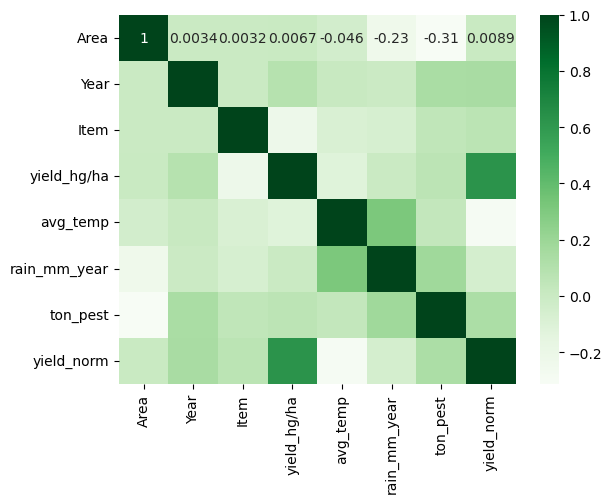

In [20]:
corr_matrix = df2.loc[:,['Area', 'Year', 'Item', 'yield_hg/ha','avg_temp','rain_mm_year', 'ton_pest', 'yield_norm']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='Greens')

Some remarkable correlations are between the amount of pesticide and the country ('ton_pest', 'Area'); the correlation between rainfall and temperature ('rain_mm_year', 'avg_temp'); and between the rainfall and the amount of pesticides ('ton_pest', 'rain_mm_year')

## Graphique


<Axes: xlabel='Year'>

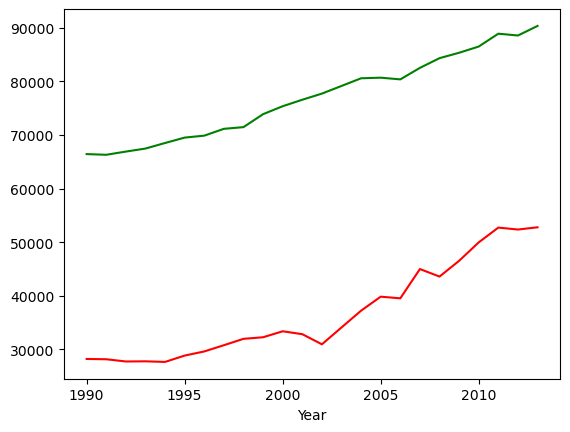

In [21]:
count_crops = df.groupby('Year')['yield_hg/ha'].mean()
count_crops.plot(color='green')

count_crops = df.groupby('Year')['ton_pest'].mean()
count_crops.plot(color='red')

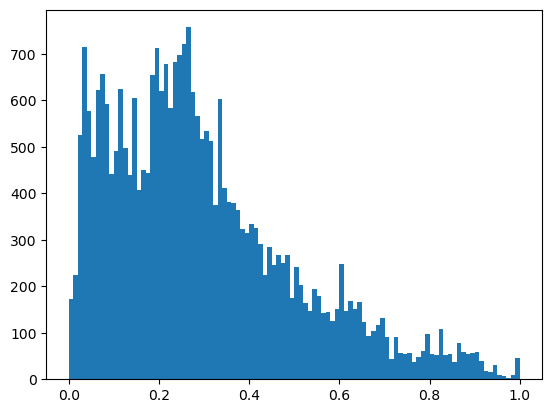

In [22]:
plt.hist(df['yield_norm'], bins=100)
plt.show()

# Model propositions

In [23]:
df_mod = df.copy()
df_mod

,Area,Item,Year,yield_hg/ha,avg_temp,rain_mm_year,ton_pest,yield_norm
0,Albania,Maize,1990,36613,16.37,1485.0,121.00,0.173018
1,Albania,Potatoes,1990,66667,16.37,1485.0,121.00,0.118175
2,Albania,"Rice, paddy",1990,23333,16.37,1485.0,121.00,0.209099
3,Albania,Sorghum,1990,12500,16.37,1485.0,121.00,0.058037
4,Albania,Soybeans,1990,7000,16.37,1485.0,121.00,0.167232
...,...,...,...,...,...,...,...,...
28243,Zimbabwe,"Rice, paddy",2013,22581,19.76,657.0,2550.07,0.201716
28244,Zimbabwe,Sorghum,2013,3066,19.76,657.0,2550.07,0.012112
28245,Zimbabwe,Soybeans,2013,13142,19.76,657.0,2550.07,0.315022
28246,Zimbabwe,Sweet potatoes,2013,22222,19.76,657.0,2550.07,0.034312


We're not considering the feature ```Year``` since we have the goal of predicting futures values of yield production.

In [24]:
numeric_attributs = ['avg_temp', 'rain_mm_year', 'ton_pest']
categorical_attributs = ['Area', 'Item']

In [25]:
from sklearn.preprocessing import LabelEncoder

X = df_mod[numeric_attributs + categorical_attributs]
y = df_mod['yield_norm']

label_encoder = LabelEncoder()
for column in categorical_attributs:
    X[column] = label_encoder.fit_transform(X[column])

/tmp/ipykernel_52185/3009179087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoder.fit_transform(X[column])
/tmp/ipykernel_52185/3009179087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoder.fit_transform(X[column])


In [26]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoosting

In [27]:
import xgboost as xg
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


clf = xg.XGBRegressor(random_state=42)

pipeline = Pipeline([
    ('model', clf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
acc = pipeline.score(X_test, y_test)
print('Erro quadrático médio: ', mse)
print('accuracy: ', acc)
print('R2: ', r2)

Erro quadrático médio:  0.002989809961611809
accuracy:  0.9293654312766192
R2:  0.9293654312766192


Text(0, 0.5, 'reference')

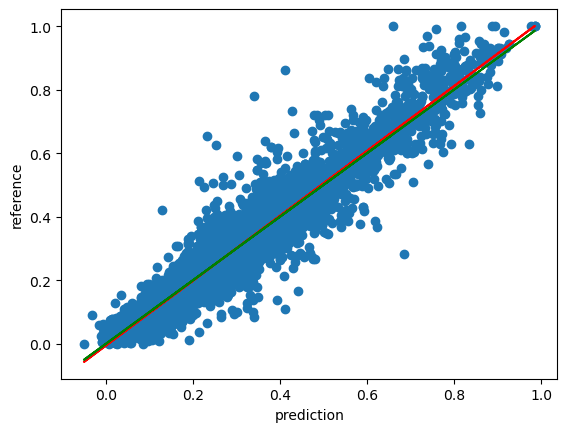

In [28]:
plt.scatter(y_pred, y_test)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m*y_pred+b, color = 'red') # regression line
plt.plot(y_pred, y_pred, color = 'green') # identity
plt.xlabel('prediction')
plt.ylabel('reference')

In [29]:
print(m, b) # we re looking for a m close to 1 and b close to 0

1.0208788255989905 -0.005608388526735201


## Random forest

In [30]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


clf = RandomForestRegressor(random_state=42)
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42)


pipeline = Pipeline([
    ('model', clf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
acc = pipeline.score(X_test, y_test)
print('Erro quadrático médio: ', mse)
print('accuracy: ', acc)
print('R2: ', r2)

Erro quadrático médio:  0.0022000223003049383
accuracy:  0.948024246236679
R2:  0.948024246236679


Text(0, 0.5, 'reference')

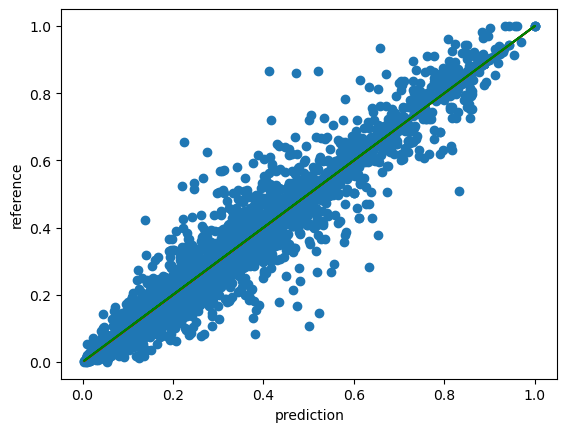

In [31]:
plt.scatter(y_pred, y_test)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m*y_pred+b, color = 'red') # regression line
plt.plot(y_pred, y_pred, color = 'green') # identity
plt.xlabel('prediction')
plt.ylabel('reference')

In [32]:
print(m, b) # we re looking for a m close to 1 and b close to 0

1.000527470311558 -0.0008015217744766921


# Dividing Data frames by Cultures

In [23]:
df_cultureGroup = df.groupby(['Item'])
df_maize = df_cultureGroup.get_group("Maize")
df_potatoes = df_cultureGroup.get_group("Potatoes")
df_rice = df_cultureGroup.get_group("Rice, paddy")
df_sorghum = df_cultureGroup.get_group("Sorghum")
df_soybeans = df_cultureGroup.get_group("Soybeans")
df_wheat = df_cultureGroup.get_group("Wheat")
df_cassava = df_cultureGroup.get_group("Cassava")
df_sweetPot = df_cultureGroup.get_group("Sweet potatoes")
df_others = df_cultureGroup.get_group("Plantains and others")
df_yams = df_cultureGroup.get_group("Yams")

In [24]:
df_parCultures = {'Maize': df_maize,
                  'Potatoes': df_potatoes,
                  'Rice, paddy': df_rice,
                  'Sorghum': df_sorghum,
                  'Soybeans': df_soybeans,
                  'Wheat': df_wheat,
                  'Cassava': df_cassava,
                  'Sweet potatoes': df_sweetPot,
                  'Plantains and others': df_others,
                  'Yams': df_yams}

In [25]:
for culture in cultures:
    print(culture,': ', df_parCultures[culture].shape)

Maize :  (4121, 8)
Potatoes :  (4276, 8)
Rice, paddy :  (3388, 8)
Sorghum :  (3039, 8)
Soybeans :  (3223, 8)
Wheat :  (3857, 8)
Cassava :  (2045, 8)
Sweet potatoes :  (2890, 8)
Plantains and others :  (556, 8)
Yams :  (847, 8)
